01. PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow. First, we import the necessary modules.

In [1]:
import torch
from torch import nn        #nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Checkout PyTorch version
torch.__version__
RANDOM_SEED = 42

In [2]:
what_were_covering={1: "data (prepare and load)",
                    2: "build model",
                    3: "fitting the model to data (training)",
                    4: "making predictions and evaluating (inference)",
                    5: "Safe and load a model",
                    6: "Putting it all together"}

## 1. Data: Preparing and loading

Data can be almost anything in machine learning. 

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like sonds or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a lienar regression formula to make a straight line with known **parameters**.

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)  # We will see later on why we need this
y = weight * X + bias

In [4]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets 

Let's create a training and test set with our data.

In [5]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

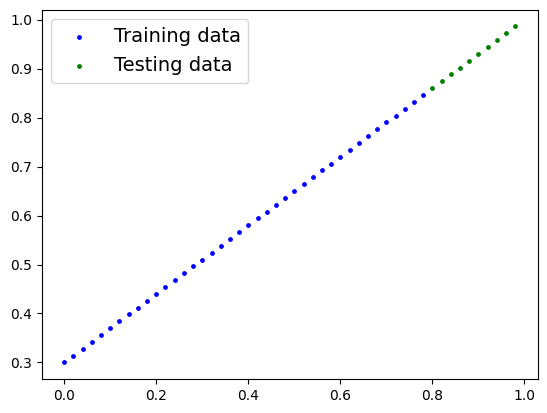

In [7]:
# Visualize data
def plot_data(train_data, train_labels, test_data, test_labels, predictions=None):
    #plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b",s=6, label="Training data")
    
    plt.scatter(test_data, test_labels, c="g",s=6, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=6, label="Predictions")
    plt.legend(prop={"size": 14})

plot_data(X_train, y_train, X_test, y_test)

## 2. Build our model

Our first PyTorch model!

What our model does:
* Start with random values for weight and bias
* Look at training data and adjust the random values to better represent the ideal values we used to create the data


How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [8]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module):     # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, 
                                               requires_grad=True,      
                                               dtype=torch.float
                                               ))
        self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True,      
                                            dtype=torch.float
                                           ))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

### PyTorch model building essentials

* `torch.nn` - contains all of the buidling blocks for neural networks
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - base class for all neural network modules, if you subclass it, you should overwrite the forward() function
* `torch.optim` - where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation



### Checking the contents of our PyTorch model

Now that we've created a model, let's see what's inside...

So we can check out model parameters or what's inside our model using `.parameters()`

In [47]:
# Create a random seed
torch.manual_seed(RANDOM_SEED)

# Create an instance of our model
model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [48]:
model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predicitive power, let's see how well it predicts `y_test` based on `X-test`.

When we pass data through our model, it's going to run it through the `forward()` method.

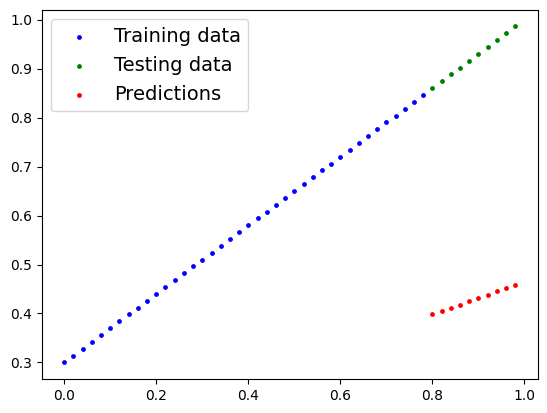

In [49]:
# Make predictions with model - Why inference_mode? Turns off gradient tracking and therefore way faster (very important on large datasets with large models!). 

with torch.inference_mode():
    y_preds = model0(X_test)

# You cna also do something similar with `torch.no_grad()`, however, `torch.inference_mode()` is preferred
#  with torch.no_grad():
#    y_preds = model0(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds)

Randomly initialized network does not perform well.

## 3. Train model

The whole idea of training is for a model to move from some unknown, possibly random, parameters to some known parameters. Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function. Things we need to train:

* **Loss function**: A function to measure how wrong our model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters. Inside the optimizer, we usually have to set two hyperparameters: `lr` (Learning rate), `params` (The parameters the model should optimize)

And for PyTorch, we need:
* A training loop
* A testing loop

In [50]:
# Setup a loss function

loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01,)                            # lr = learning rate

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust the parameters to try and improve the loss (**gradient descent**)

In [51]:
# An epoch (hyperparameter) is one loop through the data
epochs  = 200

# Tracking experiments
epoch_count = []
loss_values = []
test_loss_values = []

# Step 0: Loop through the data
for epoch in range(epochs):
    model0.train()              # train mode in PyTorch sets all parameters that require gradients to require gradients

    # Step 1: Forward pass
    y_pred = model0(X_train)

    # Step 2: Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f"Loss: {loss}")

    # Step 3: Optimizer zero grad
    optimizer.zero_grad()   # Reset the gradients of all optimized torch.Tensors to zero

    # Step 4: Perform backpropagation on the loss with respect to the model's parameters
    loss.backward()         # Computes the gradients of the loss function wrt. all the parameters

    # Step 5: Step the optimizer (perform gradient descent)
    optimizer.step()        # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop

    # Testing
    model0.eval()           # turns off different settings in the model not needed for evaluation/testing, for example, dropout layers are turned off.
    with torch.inference_mode():        # turns off gradient tracking (torch.inference_mode is torch.no_grad on steroids)
        # Forward pass
        test_pred = model0(X_test)
        # Calculate loss
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713389158249 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.2172965705394745
Epoch: 30 | Loss: 0.053148530423641205 | Test loss: 0.14464019238948822
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953748226166
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633813381195
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937722325325
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.027887403964996338 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458955973386765 | Test loss: 0.056463055312633514
Epoch: 110 | Loss: 0.021020209416747093 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546754717827 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155390672385693 | Test loss: 0.03233228251338005
E

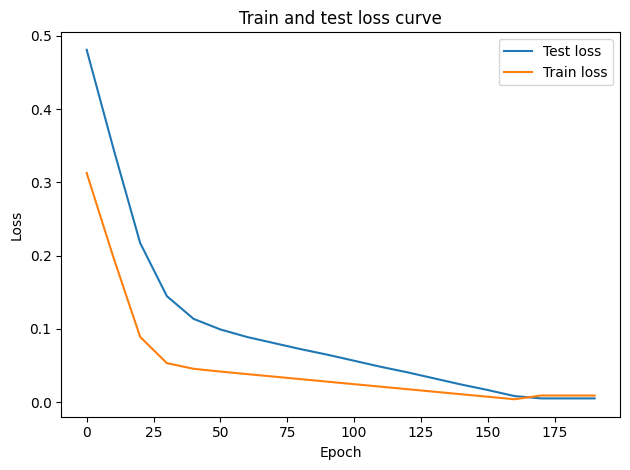

In [60]:
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss curve")
plt.legend()
plt.tight_layout()

Very close to the actual values

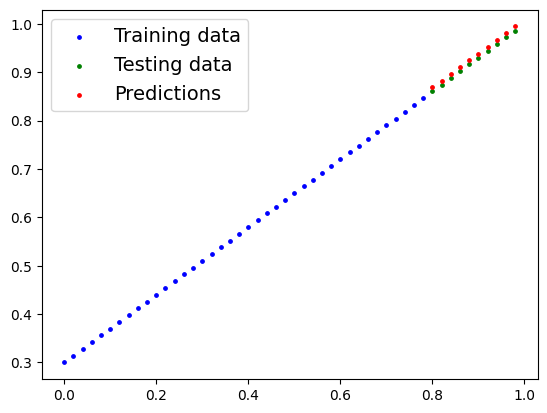

In [52]:
with torch.inference_mode():
    y_preds_new = model0(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds_new)

In [61]:
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating (inference)',
 5: 'Safe and load a model',
 6: 'Putting it all together'}

## 4. Saving a model in PyTorch

There are three main methods you should know about for saving and laoding models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch obeject in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

What is a `state_dict`? - In PyTorch, the learnable parameters of an torch.nn.Module model are contained in the model's parameters. A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

In [ ]:
# Saving our PyTorch model

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])